In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import KID_S21 as S21
import pandas as pd
import pickle
from copy import copy
import glob 

import matplotlibcolors
plt.style.use('matplotlibrc')

%matplotlib widget

In [120]:
dir  = r"C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\sonnet\LT402 Design/"
chip = 'LT402_32x32_4-8GHz'
path = dir + chip + '/'
with open('LT402chip6_master.pkl', 'rb') as f:
    master = pickle.load(f)
kid_id_board = np.load( path + chip + '_id.npy')
f0_mapped = master['measured']['f0']


In [121]:
dir = r'Z:\KIDonSun\experiments\Entropy ADR\LT402chip6_BF_20250919\S21\Power/'
df = S21.loop_over_S21_files(dir, kid=1, pread=100, plot=True)
display(df)
# with open('LT402chip6_Qs.pkl', 'wb') as f:
#     pickle.dump(df, f)

# with open('LT402chip6_Qs.pkl', 'rb') as f:
#     df = pickle.load(f)
# display(df)

,KID,Power,Temperature,f0,f0_std,Ql,Ql_std,Qc,Qc_std,Qi,Qi_std,Pint


filtered: 556 / 997


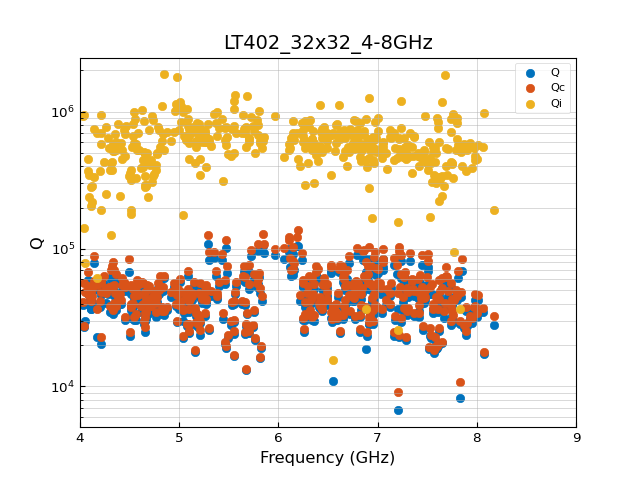

In [113]:
f0_Q = df['f0']
Ql = df['Ql']
Qc = df['Qc']
Qi = df['Qi']
phi = df['phi']

min_df = 0.0005
df0s = np.asarray(f0_Q)[1:] - np.asarray(f0_Q)[:-1]
too_close = df0s < min_df
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))

Qi_mask = (Qi > 1e4) & (Qi < 2e6)
Qc_mask = Qc < 1.5e5
mask = Qi_mask & Qc_mask & ~too_close_mask
# mask = np.ones(len(df), dtype=bool)  # all
df_filtered = copy(df)
df_filtered[~mask] = np.nan
f0_Q = df_filtered['f0']
Ql = df_filtered['Ql']
Qc = df_filtered['Qc']
Qi = df_filtered['Qi']
phi = df_filtered['phi']
print('filtered:', np.sum(mask==False), '/', len(mask))
fig, ax = plt.subplots()
ax.set_title(chip)
ax.set_yscale('log')
ax.scatter(f0_Q, Ql, label='Q')
ax.scatter(f0_Q, Qc, label='Qc')
ax.scatter(f0_Q, Qi, label='Qi')
ax.set_xlim(4,9)
ax.set_xlabel('Frequency (GHz)')    
# ax.set_ylim(1e4,2e6)
ax.set_ylabel('Q')
ax.legend()

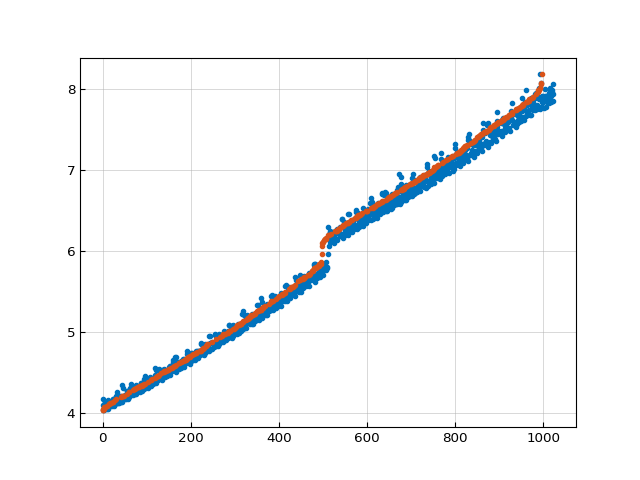

In [115]:
fig, ax = plt.subplots()
ax.plot(f0_mapped, '.')
ax.plot(f0_Q, '.')

In [116]:
nr = len(f0_mapped)
f0_dark = f0_Q
idxs = np.empty(nr)
idxs[:] = np.nan
for id, f0 in enumerate(f0_mapped):
    if ~np.isnan(f0):
        closest =  np.nanargmin(np.abs(f0 - f0_dark))
        if ~np.isnan(f0_dark[closest]):
            tone = f0_dark[closest]
            if closest in idxs:
                idx_location = np.where(idxs == closest)[0]
                if len(idx_location) == 1:
                    prev_id = idx_location[0]
                    prev_f0 = f0_mapped[prev_id]
                    curr_diff = np.abs(f0 - tone)
                    prev_diff = np.abs(prev_f0 - tone)
                    if curr_diff < prev_diff:
                        idxs[prev_id] = np.nan
                    else:
                        closest = np.nan
                else:
                    print('more than one match')
                    closest = np.nan
            else:
                pass
        else:
            closest = np.nan
    else:
        closest = np.nan
    idxs[id] = closest
print(idxs)


[ nan   0.  nan ... 967.  nan 994.]


In [117]:
df_sorted = pd.DataFrame(np.nan, index=np.arange(nr), columns=df_filtered.columns)
for i, idx in enumerate(idxs):
    if ~np.isnan(idx):
        df_sorted.iloc[i] = df_filtered.iloc[int(idx)]
    else:
        pass

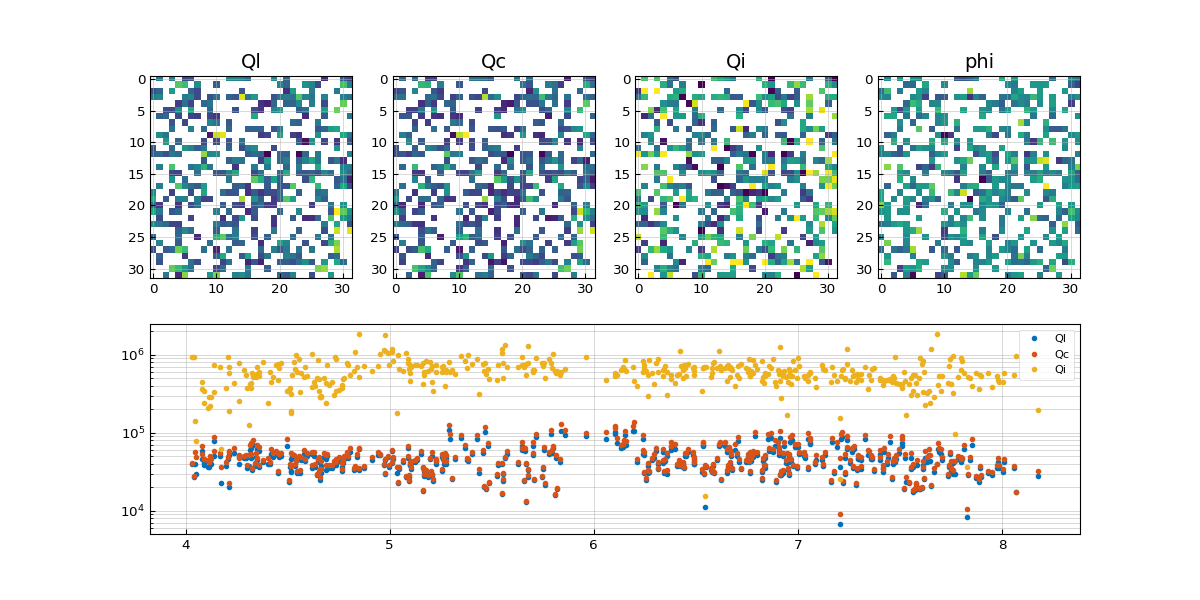

In [118]:
fig, axes = plt.subplot_mosaic('abcd;eeee', figsize=(12,6))
Ql = np.asarray(df_sorted['Ql'])
Qi = np.asarray(df_sorted['Qi'])
Qc = np.asarray(df_sorted['Qc'])
phi = np.asarray(df_sorted['phi'])
ax = axes['a']
ax.imshow(Ql[kid_id_board])
ax.set_title('Ql')
ax = axes['b']
ax.imshow(Qc[kid_id_board])
ax.set_title('Qc')
ax = axes['c']
ax.imshow(Qi[kid_id_board], vmin=2e5, vmax=1e6)
ax.set_title('Qi')
ax = axes['d']
ax.imshow(phi[kid_id_board])
ax.set_title('phi')
ax = axes['e']
ax.plot(f0_mapped, Ql, '.', label='Ql')
ax.plot(f0_mapped, Qc, '.', label='Qc')
ax.plot(f0_mapped, Qi, '.', label='Qi')
ax.set_yscale('log')
ax.legend()


In [74]:
keys = ['Ql', 'Qi', 'Qc', 'phi']
for key in keys:
    master['measured'][key] = np.asarray(df_sorted[key])

In [75]:
# with open('LT402chip6_master.pkl', 'wb') as f:
#     pickle.dump(master, f)